Cell 1: Setup & Imports

In [ ]:
# 1. Clone & install CycleGAN repo
#!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix
#!pip install -r requirements.txt

# 2. Imports
import os, glob, time
from PIL import Image
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from facenet_pytorch import MTCNN

Cell 2: Create Folders & (Optionally) Capture Real Faces

In [2]:
root = '../data'
for d in ('trainA','trainB','testA','testB'):
    os.makedirs(f'{root}/{d}', exist_ok=True)

# Optional: populate trainA via webcam until ~4000 images
cap = cv2.VideoCapture(0)
count = len(glob.glob(f'{root}/trainA/*.jpg'))
while count < 4000:
    ret, frame = cap.read()
    if not ret: break
    cv2.imshow('Press SPACE to save, Q to quit', frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord(' '):
        cv2.imwrite(f'{root}/trainA/{count:04d}.jpg', frame)
        count += 1
    if key & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


Cell 3: Start training from scratch

In [ ]:

!python train.py \
  --dataroot ../data \
  --name cartoon_cyclegan2 \
  --model cycle_gan \
  --batch_size 4 \
  --n_epochs 50 \
  --n_epochs_decay 50 \
  --num_threads 4 \
  --gpu_ids 0 \
  --verbose \


Cell 4: Resume training (after an interrupt)

In [3]:

!python train.py \
  --dataroot ../data \
  --name cartoon_cyclegan2 \
  --model cycle_gan \
  --batch_size 4 \
  --n_epochs 9 \
  --n_epochs_decay 50 \
  --num_threads 4 \
  --gpu_ids 0 \
  --verbose \
  --display_id 0 \
  --continue_train \
  --epoch_count 41


^C


Cell 5: Test / Single-Image Inference

In [19]:
!python test.py \
    --dataroot ../data \
    --name cartoon_cyclegan2 \
    --model cycle_gan \
    --phase test \
    --num_test 10 \


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../data                       	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

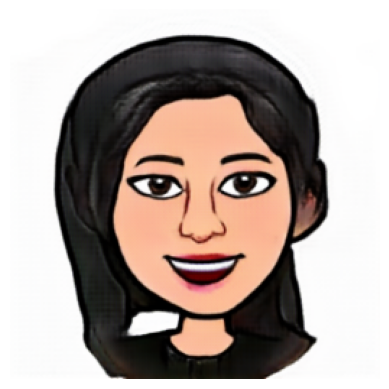

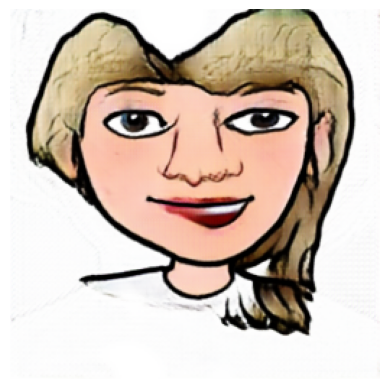

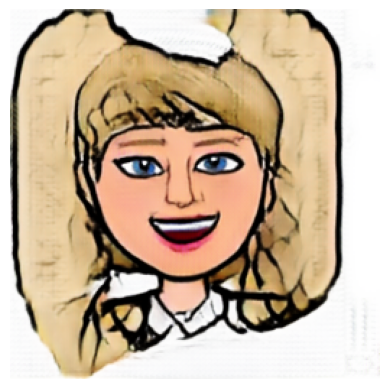

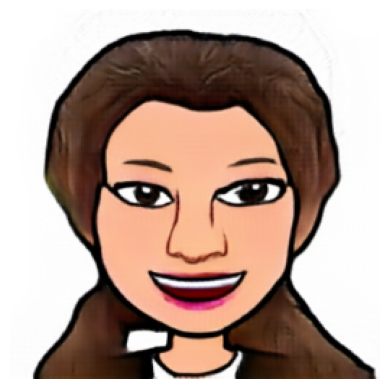

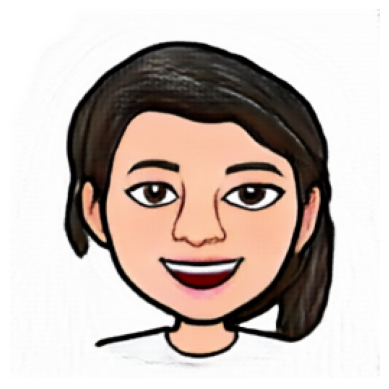

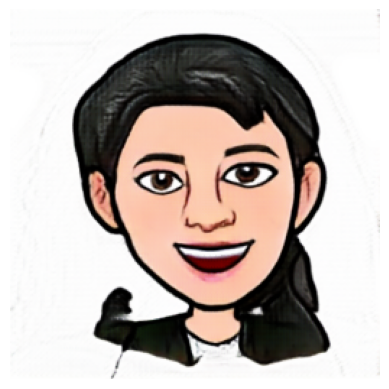

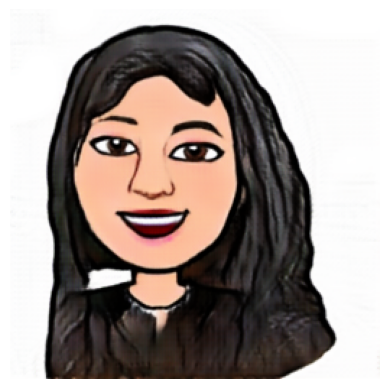

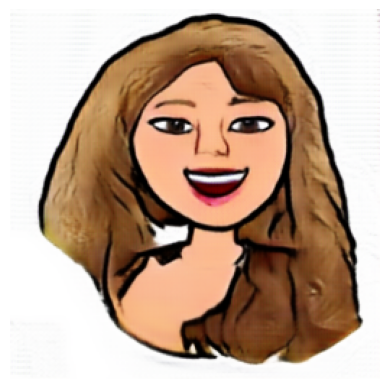

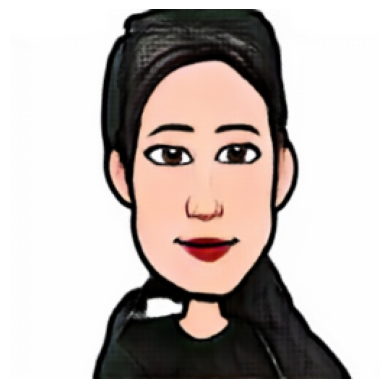

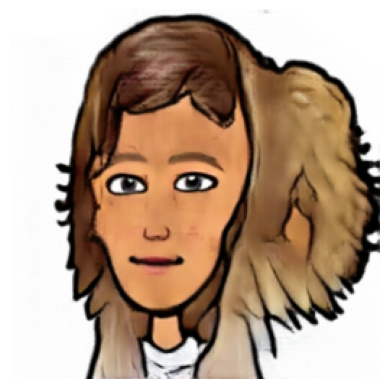

In [3]:
# display a few results
import matplotlib.pyplot as plt

out_dir = 'results/cartoon_cyclegan2/test_latest/images'
pairs   = glob.glob(f'{out_dir}/*_fake_B.png')[:10]
for p in pairs:
    img = Image.open(p)
    plt.imshow(np.array(img)); plt.axis('off'); plt.show()


Cell 6: Live Webcam Cartoonify

In [3]:
import sys
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from options.test_options import TestOptions
from models import create_model

# ── 1) Parse TestOptions via sys.argv ─────────────────────────────────────────
sys.argv = [
    'test_full_with_sliders.py',
    '--dataroot',   '../data',
    '--name',       'cartoon_cyclegan2',
    '--model',      'cycle_gan',
    '--phase',      'test',
    '--num_test',   '1',
]
opt = TestOptions().parse()      # uses load_size=256, crop_size=256
model = create_model(opt)
model.setup(opt)
model.eval()

# ── 2) Build full-frame preprocessing transform ───────────────────────────────
preprocess = transforms.Compose([
    transforms.Resize((opt.load_size, opt.load_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

# ── Helper: apply brightness, contrast & gamma ────────────────────────────────
def apply_b_c_g(img, brightness=0, contrast=1.0, gamma=1.0):
    """
    img:        uint8 BGR image [0,255]
    brightness: -100..+100 (beta)
    contrast:    0.00..2.00   (alpha)
    gamma:       >0          (gamma)
    """
    # 1) brightness & contrast
    bc = cv2.convertScaleAbs(img, alpha=contrast, beta=brightness)
    # 2) gamma correction via LUT
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(256)]).astype('uint8')
    return cv2.LUT(bc, table)

# ── 3) Start capture, create sliders & inference loop ─────────────────────────
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Could not open webcam (index 0)")

# Create a window for trackbars
cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)
# Brightness: 0–200 (100 = no change)
cv2.createTrackbar('Brightness', 'Controls', 100, 200, lambda x: None)
# Contrast:   0–200 (100 = no change)
cv2.createTrackbar('Contrast',   'Controls', 100, 200, lambda x: None)
# Gamma:      1–300 (100 = γ=1.0)
cv2.createTrackbar('Gamma',      'Controls', 100, 300, lambda x: None)

print("Press 'q' to quit.")

with torch.no_grad():
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # --- read slider values & map to parameters ---
        beta  = cv2.getTrackbarPos('Brightness', 'Controls') - 100
        alpha = cv2.getTrackbarPos('Contrast',   'Controls') / 100.0
        gamma = cv2.getTrackbarPos('Gamma',      'Controls') / 100.0

        # --- apply sliders only to the model input ---
        adj_frame = apply_b_c_g(frame, brightness=beta, contrast=alpha, gamma=gamma)

        # --- preprocess & stylize ---
        img_pil   = Image.fromarray(cv2.cvtColor(adj_frame, cv2.COLOR_BGR2RGB))
        tensor_in = preprocess(img_pil).unsqueeze(0).to(model.device)
        fake      = model.netG_A(tensor_in)

        # --- denormalize & convert to BGR for display ---
        fake_np  = fake.squeeze(0).cpu().permute(1,2,0).numpy()    # in [-1,1]
        fake_img = ((fake_np + 1) * 0.5 * 255).clip(0,255).astype(np.uint8)
        fake_bgr = cv2.cvtColor(fake_img, cv2.COLOR_RGB2BGR)

        # --- resize back to original webcam size & show ---
        h, w = frame.shape[:2]
        full_output = cv2.resize(fake_bgr, (w, h), interpolation=cv2.INTER_LINEAR)
        cv2.imshow('Cartoonify Full Frame', full_output)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../data                       	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            